In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# to get deterministic output
tf.random.set_seed(123)

sys.path.append(os.path.abspath(".."))

### Loading the Dataset

In [2]:
df = pd.read_csv("../datasets/perceptron_toydata-truncated.txt", sep="\t")
df

,x1,x2,label
0,0.77,-1.14,0
1,-0.33,1.44,0
2,0.91,-3.07,0
3,-0.37,-1.91,0
4,-0.63,-1.53,0
5,0.39,-1.99,0
6,-0.49,-2.74,0
7,-0.68,-1.52,0
8,-0.10,-3.43,0
9,-0.05,-1.95,0


In [3]:
X_train = df[["x1", "x2"]].values
y_train = df["label"].values

print("Train set:", X_train.shape, y_train.shape)

Train set: (20, 2) (20,)


In [4]:
# scaling for better convergence
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [5]:
print("Training labels:")
counts = Counter(y_train)
for key, value in counts.items():
    print(f"{key}: {value}")

Training labels:
0: 10
1: 10


### Visualize the Dataset

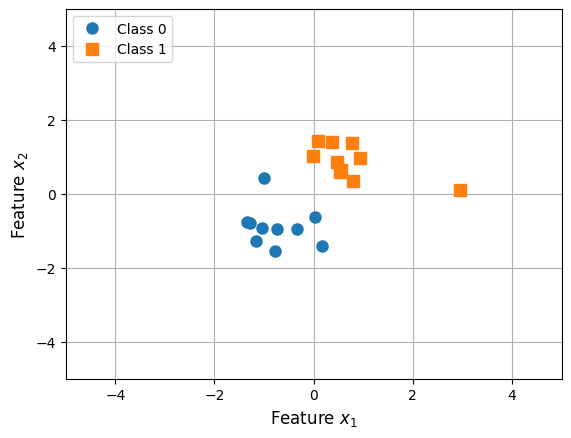

In [6]:
from modules.plotting_helper import plot_feature2d
plot_feature2d(X_train, y_train, markersize=8)

### Define the DataLoader

In [7]:
# Reshape labels
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
y_train_reshape = y_train.reshape(-1, 1)

# TensorFlow dataset for mini-batching
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_reshape)).shuffle(buffer_size=1024).batch(batch_size=10)

### Design the Model

In [8]:
# ===== Logistic Regression model =====
class LogisticRegression():
    def __init__(self, input_dim):
        self.weights = tf.Variable(tf.zeros(shape=(input_dim, 1), dtype=tf.float32))
        self.bias = tf.Variable(tf.zeros(shape=(1), dtype=tf.float32))
    
    def __call__(self, x):
        logits = tf.matmul(x, self.weights) + self.bias
        return logits
    
    def predict(self, x):
        return tf.sigmoid(self(x))
    
    def parameters(self):
        return [self.weights, self.bias]

# ===== Optimizer (manual SGD) =====
class SGD:
    def __init__(self, learning_rate):
        self.lr = learning_rate

    def apply_gradients(self, grads_and_vars):
        for g, p in grads_and_vars:
            p.assign_sub(self.lr * g)
    
# ===== Loss function =====  
def binary_cross_entropy_with_logits(y_true, logits):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=logits))
    
model = LogisticRegression(input_dim=2)
optimizer = SGD(learning_rate=1.00)

### Train the model

In [9]:
def train(model, num_epochs):
    history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (x_batch, y_batch) in enumerate(train_ds):
            # forward pass
            with tf.GradientTape() as tape:                                
                logits = model(x_batch)
                loss = binary_cross_entropy_with_logits(y_batch, logits)
            
            # backward pass
            gradients = tape.gradient(loss, model.parameters())
            optimizer.apply_gradients(zip(gradients, model.parameters()))

            epoch_loss += abs(loss.numpy())
            history.append(loss.numpy())
            print(f' -> batch: {batch_idx+1:03d} | loss: {loss:.2f}')
            
        print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | epoch_loss: {epoch_loss:.2f}')
    return history
        
history = train(model, num_epochs=20)

 -> batch: 001 | loss: 0.69
 -> batch: 002 | loss: 0.43
Epoch: 001/020 | epoch_loss: 1.12
 -> batch: 001 | loss: 0.28
 -> batch: 002 | loss: 0.27
Epoch: 002/020 | epoch_loss: 0.54
 -> batch: 001 | loss: 0.18
 -> batch: 002 | loss: 0.19
Epoch: 003/020 | epoch_loss: 0.37
 -> batch: 001 | loss: 0.18
 -> batch: 002 | loss: 0.12
Epoch: 004/020 | epoch_loss: 0.30
 -> batch: 001 | loss: 0.16
 -> batch: 002 | loss: 0.09
Epoch: 005/020 | epoch_loss: 0.25
 -> batch: 001 | loss: 0.14
 -> batch: 002 | loss: 0.07
Epoch: 006/020 | epoch_loss: 0.22
 -> batch: 001 | loss: 0.10
 -> batch: 002 | loss: 0.09
Epoch: 007/020 | epoch_loss: 0.19
 -> batch: 001 | loss: 0.08
 -> batch: 002 | loss: 0.09
Epoch: 008/020 | epoch_loss: 0.17
 -> batch: 001 | loss: 0.06
 -> batch: 002 | loss: 0.10
Epoch: 009/020 | epoch_loss: 0.16
 -> batch: 001 | loss: 0.05
 -> batch: 002 | loss: 0.09
Epoch: 010/020 | epoch_loss: 0.14
 -> batch: 001 | loss: 0.05
 -> batch: 002 | loss: 0.09
Epoch: 011/020 | epoch_loss: 0.14
 -> batch:

In [10]:
bias = model.bias.numpy()
weights = model.weights.numpy()
print("Bias:", bias)
print("Weights:", weights)

Bias: [-0.17775175]
Weights: [[2.3202603]
 [2.669406 ]]


### Evaluate the Model

In [11]:
predictions = model.predict(X_train)
y_preds = tf.cast(predictions >= 0.5, tf.float32)

train_acc = accuracy_score(y_train, y_preds)
print(f"Train Accuracy: {train_acc:.2f}")

cmat = confusion_matrix(y_train, y_preds)
print("Confusion Matrix:")
print(cmat)

Train Accuracy: 1.00
Confusion Matrix:
[[10  0]
 [ 0 10]]


### Vizualize the Results

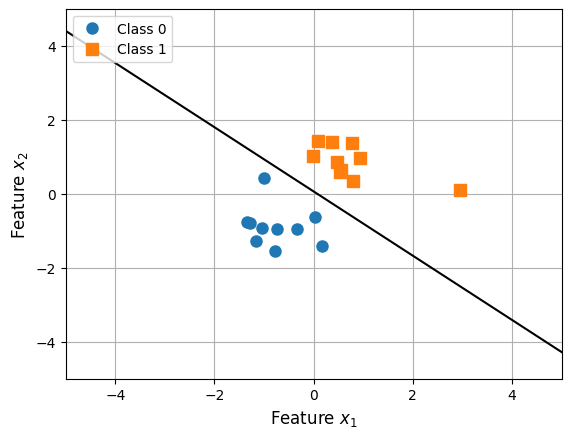

In [12]:
plot_feature2d(X_train, y_train, bias, weights, markersize=8)